## Notebook for hyperparameter-tuning for Teacher Forcing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from models.data_generating_models.teacher_forcing import TeacherForcing
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config
from models.DeepHedger import hedging
from config import data_generation_config
import wandb

## Define train and val data

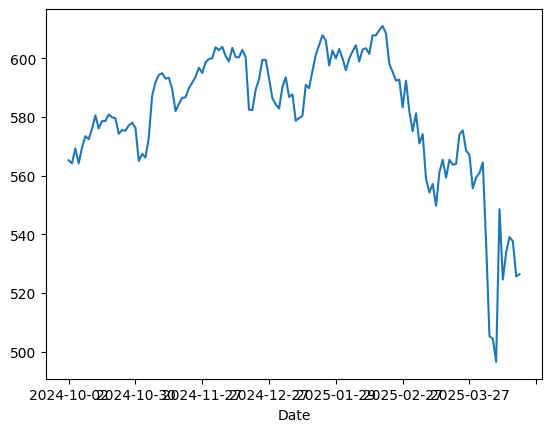

In [2]:
train_data = pd.read_csv("../data/raw/spy_daily_closing_prices_train.csv", index_col=0)

val_data = pd.read_csv("../data/raw/spy_daily_closing_prices_val.csv", index_col=0)

val_data = val_data["Close"]
val_data.plot(use_index=True)
val_data = np.array([val_data.values[i:i+30] for i in range(len(val_data)-30 + 1)])
val_data = pd.DataFrame(val_data)
val_data = val_data.div(val_data.iloc[:, 0], axis=0)

test_data = pd.read_csv("../data/raw/spy_daily_closing_prices_test.csv", index_col=0)
test_data = test_data["Close"]
test_data = np.array([test_data.values[i:i+30] for i in range(len(test_data)-30 + 1)])
test_data = pd.DataFrame(test_data)
test_data = test_data.div(test_data.iloc[:, 0], axis=0)

In [3]:
wandb.login(key="52ea61320bbc9ee2b773e909700366e65977cd0f")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sarogde (sarogde-ntnu). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/sondrerogde/.netrc


True

In [7]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'noise_scale': {
            'distribution': 'uniform',
            'min': 0.01,
            'max': 0.15
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.001,
            'max': 0.1
        },
        'hidden_size': {
            'values': [4, 8,16, 32]
        },
    }
}

In [5]:
# sweep_id = wandb.sweep(sweep_config, project="teacher_forcing_hyperopt")
sweep_id = "nukpz5jx"

Create sweep with ID: nukpz5jx
Sweep URL: https://wandb.ai/sarogde-ntnu/teacher_forcing_hyperopt/sweeps/nukpz5jx


In [8]:
def objective(config):
    hyperparameters = {
            "noise_scale": config.noise_scale,
            "learning_rate": config.learning_rate,
            "hidden_size": config.hidden_size
        }
    
    model = TeacherForcing(train_data=train_data, N=100000, M=30, load_params=False, config=hyperparameters)
    model.generate_data()

    df_post_processed = post_processing(model.synth_data, **post_processing_config)

    print('Hedging')
    val_loss = hedging(df_post_processed, val_data)

    return val_loss

def main():
    wandb.init()
    val_loss = objective(wandb.config)
    wandb.log({"val_loss": val_loss,  "loss": val_loss})

In [ ]:
wandb.agent(sweep_id, function=main, count=10, project="teacher_forcing_hyperopt")

## Testing

In [ ]:
optimal_hyperparameters = {
    "noise_scale": 0.026025532329778535,
    "learning_rate": 0.06521272012375612,
    "hidden_size": 4
}

model_name = "t_forcing"

In [16]:
val_losses = [] 
test_losses = []

for i in range(5):
    model = TeacherForcing(train_data=train_data, N=100000, M=30, load_params=False, config=optimal_hyperparameters)
    model.generate_data()

    df_post_processed = post_processing(model.synth_data, **post_processing_config)

    print('Hedging')
    val_loss, test_loss = hedging(df_post_processed, val_data, test_data)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    print(f"Validation loss: {val_loss}, Test loss: {test_loss}")

print(f"Average validation loss: {np.mean(val_losses)}, Average test loss: {np.mean(test_losses)}")
df_post_processed.iloc[:10_000,:].to_csv(f"../data/processed/{model_name}_synth_data.csv")

Epoch 100, Loss: 0.0013599703088402748
Epoch 200, Loss: 0.0013282927684485912
Epoch 300, Loss: 0.0011794338934123516
Epoch 400, Loss: 0.0013223782880231738
Epoch 500, Loss: 0.0012735860655084252
Epoch 600, Loss: 0.0018483491148799658
Epoch 700, Loss: 0.0005055865040048957
Epoch 800, Loss: 0.0006109040696173906
Epoch 900, Loss: 0.00012666861584875733
Epoch 1000, Loss: 0.00011421651288401335


## Saving mean and std of losses in latex

In [25]:
# Create LaTeX table with results
val_mean = np.mean(val_losses)
val_std = np.std(val_losses)
test_mean = np.mean(test_losses)
test_std = np.std(test_losses)

latex_table = f"""
\\begin{{table}}[h]
\\centering
\\begin{{tabular}}{{lc}}
\\hline
Metric & Value \\\\
\\hline
Validation Loss & {val_mean:.6f} $\\pm$ {val_std:.6f} \\\\
Test Loss & {test_mean:.6f} $\\pm$ {test_std:.6f} \\\\
\\hline
\\end{{tabular}}
\\caption{{Validation and Test Loss Statistics}}
\\label{{tab:loss_stats}}
\\end{{table}}
"""

with open(f'../data/performance/{model_name}.tex', 'w') as f:
    f.write(latex_table)
